In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Perceptron, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tabulate import tabulate
import math

In [41]:
#compute the Radial Basis Function (RBF) kernel transformation.
def rbf_kernel_data(X, centers, gamma):
    return np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - centers, axis=2) ** 2)

#train the second layer using Linear Regression
def train_second_layer_data(X_rbf, y):
    # initialize Linear Regression model
    model = LinearRegression()

    # train the model
    model.fit(X_rbf, y)
    return model

In [8]:
#model selection for the Radial Basis Function (RBF) network
def model_selection_rbf_data(X_train, y_train, gammas):
    """Perform model selection for RBF network."""
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_gamma_data = None
    best_avg_rmse_data = float('inf')
    best_dof_data = None
    best_noc_data = None

    for gamma_data in gammas:
        rmse_scores_data = []
        dof_data_scores = []
        noc_data_scores = []

        for train_index_data, val_index_data in kf.split(X_train):
            X_train_fold_data, X_val_fold_data = X_train[train_index_data], X_train[val_index_data]
            y_train_fold_data, y_val_fold_data = y_train[train_index_data], y_train[val_index_data]

            centers_data = X_train_fold_data
            X_rbf_train_data = rbf_kernel_data(X_train_fold_data, centers_data, gamma_data)
            X_rbf_val_data = rbf_kernel_data(X_val_fold_data, centers_data, gamma_data)

            model_data = train_second_layer_data(X_rbf_train_data, y_train_fold_data)
            dof_data = (len(model_data.coef_) + 1)
            noc_data = len(X_rbf_train_data)

            y_pred_data = model_data.predict(X_rbf_val_data)

            rmse_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_data))
            rmse_scores_data.append(rmse_data)
            dof_data_scores.append(dof_data)
            noc_data_scores.append(noc_data)

        avg_rmse_data = np.mean(rmse_scores_data)
        avg_dof_data = np.mean(dof_data_scores)
        avg_noc_data = np.mean(noc_data_scores)

        if avg_rmse_data < best_avg_rmse_data:
            best_avg_rmse_data = avg_rmse_data
            best_gamma_data = gamma_data
            best_dof_data = avg_dof_data
            best_noc_data = avg_noc_data

    return best_gamma_data, best_avg_rmse_data, best_dof_data, best_noc_data

In [9]:
def model_selection_rbf_kmeans_data(X_train, y_train, gammas, K_range):
    """Perform model selection for RBF network with K-means."""
    best_gamma_data = None
    best_K_data = None
    best_avg_rmse_data = float('inf')
    best_dof_data = None
    best_noc_data = None

    for gamma_data in gammas:
        for K_data in K_range:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            avg_rmse_scores_data = []
            dof_data_scores = []
            noc_data_scores = []

            for train_index_data, val_index_data in kf.split(X_train):
                X_train_fold_data, X_val_fold_data = X_train[train_index_data], X_train[val_index_data]
                y_train_fold_data, y_val_fold_data = y_train[train_index_data], y_train[val_index_data]

                kmeans_data = KMeans(n_clusters=K_data, init='random', n_init=10, random_state=42)
                kmeans_data.fit(X_train_fold_data)
                centers_data = kmeans_data.cluster_centers_

                X_rbf_train_data = rbf_kernel_data(X_train_fold_data, centers_data, gamma_data)
                X_rbf_val_data = rbf_kernel_data(X_val_fold_data, centers_data, gamma_data)

                model_data = train_second_layer_data(X_rbf_train_data, y_train_fold_data)
                dof_data = (len(model_data.coef_) + 1)
                noc_data = len(X_rbf_train_data)

                y_pred_data = model_data.predict(X_rbf_val_data)

                rmse_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_data))
                avg_rmse_scores_data.append(rmse_data)
                dof_data_scores.append(dof_data)
                noc_data_scores.append(noc_data)

            avg_rmse_data = np.mean(avg_rmse_scores_data)
            avg_dof_data = np.mean(dof_data_scores)
            avg_noc_data = np.mean(noc_data_scores)

            if avg_rmse_data < best_avg_rmse_data:
                best_avg_rmse_data = avg_rmse_data
                best_gamma_data = gamma_data
                best_K_data = K_data
                best_dof_data = avg_dof_data
                best_noc_data = avg_noc_data

    return best_gamma_data, best_K_data, best_avg_rmse_data, best_dof_data, best_noc_data

In [42]:
# Plot training and validation RMSE against gamma
def plot_rmse_vs_gamma_data(gammas, avg_train_rmse_data, avg_val_rmse_data):
    plt.plot(gammas, avg_train_rmse_data, label='Training RMSE')
    plt.plot(gammas, avg_val_rmse_data, label='Validation RMSE')
    plt.xlabel('Gamma')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. Gamma')
    plt.xscale('log')
    plt.legend()
    plt.show()
    
#helpful in understanding data distribution
def plot_data_and_centers_data(X_train, centers):
    # Scatter plot of training data points
    plt.scatter(X_train[:, 0], X_train[:, 1], label='Training Data', marker='.')
    
    # Scatter plot of cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], label='Cluster Centers', marker='x')
    
    # Labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Training Data and Cluster Centers')
    
    # Legend
    plt.legend()
    
    # Show plot
    plt.show()
    
# helps in evaluating the performance of the model with different numbers of clusters K
def plot_rmse_vs_K_data(K_range, avg_val_rmse_list_data, std_val_rmse_list_data):
    # Plot validation RMSE against K with error bars for standard deviation
    plt.errorbar(K_range, avg_val_rmse_list_data, yerr=std_val_rmse_list_data, fmt='o-', label='Validation RMSE')
    
    # Labels and title
    plt.xlabel('K')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE vs. K')
    
    # Legend
    plt.legend()
    
    # Show plot
    plt.show()

In [40]:
#1: Load the data 
train_data_df = pd.read_csv('HW7_Pr1_S24_test_data.csv')
test_data_df = pd.read_csv('HW7_Pr1_S24_training_data.csv')

X_train_data = train_data_df.iloc[:, :-1].values
y_train_data = train_data_df.iloc[:, -1].values

X_test_data = test_data_df.iloc[:, :-1].values
y_test_data = test_data_df.iloc[:, -1].values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize list to store RMSE for each fold
rmse_scores_data = []

# Iterate over each fold
for train_index, val_index in kf.split(X_train_data):
    # Split data into training and validation sets
    X_train_fold_data, X_val_fold_data = X_train_data[train_index], X_train_data[val_index]
    y_train_fold_data, y_val_fold_data = y_train_data[train_index], y_train_data[val_index]

    # Initialize and train linear regression model
    model_data = LinearRegression()
    model_data.fit(X_train_fold_data, y_train_fold_data)

    # Predict on validation set
    y_pred_data = model_data.predict(X_val_fold_data)

    # Calculate RMSE for current fold
    rmse_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_data))
    rmse_scores_data.append(rmse_data)

# Calculate average RMSE across all folds
avg_rmse_data = np.mean(rmse_scores_data)

print("Average RMSE on validation training sets using linear regression:", avg_rmse_data)

gammas_data = [0.01, 0.1, 1, 10, 100]
best_gamma_data, best_avg_rmse_data, best_dof_data, best_noc_data = model_selection_rbf_data(X_train_data, y_train_data, gammas_data)
print("Best gamma:", best_gamma_data)
print("Cross-validation average RMSE:", best_avg_rmse_data)
print("Degrees of freedom (dof):", best_dof_data)
print("Number of centers (noc):", best_noc_data)

Average RMSE on validation training sets using linear regression: 2.5158158730770204
Best gamma: 10
Cross-validation average RMSE: 1.6752470824789094e-05
Degrees of freedom (dof): 801.0
Number of centers (noc): 800.0


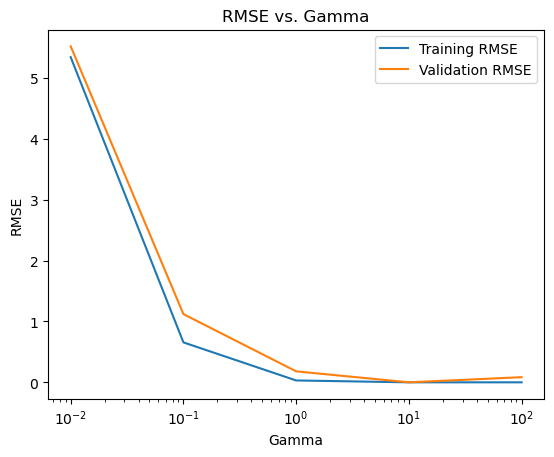

In [17]:
# Initialize lists to store average training and validation RMSE values
avg_train_rmse_list_data = []
avg_val_rmse_list_data = []

# Initialize KFold cross-validation with 5 splits, shuffling, and fixed random state
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over each gamma value in the list of gammas_data
for gamma_data in gammas_data:
    # Initialize lists to store RMSE values for each fold
    rmse_train_list_data = []
    rmse_val_list_data = []
    
    # Perform KFold cross-validation
    for train_index_data, val_index_data in kf.split(X_train_data):
        # Split data into training and validation sets
        X_train_fold_data, X_val_fold_data = X_train_data[train_index_data], X_train_data[val_index_data]
        y_train_fold_data, y_val_fold_data = y_train_data[train_index_data], y_train_data[val_index_data]

        # Use data points as centers for the RBF kernel transformation
        centers_data = X_train_fold_data
        X_rbf_train_data = rbf_kernel_data(X_train_fold_data, centers_data, gamma_data)
        X_rbf_val_data = rbf_kernel_data(X_val_fold_data, centers_data, gamma_data)

        # Train the second layer model using linear regression
        model_data = train_second_layer_data(X_rbf_train_data, y_train_fold_data)
        
        # Predict on both training and validation sets
        y_pred_train_data = model_data.predict(X_rbf_train_data)
        y_pred_val_data = model_data.predict(X_rbf_val_data)

        # Compute RMSE for training and validation sets and append to lists
        rmse_train_data = np.sqrt(mean_squared_error(y_train_fold_data, y_pred_train_data))
        rmse_val_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_val_data))
        rmse_train_list_data.append(rmse_train_data)
        rmse_val_list_data.append(rmse_val_data)

    # Calculate the average RMSE values for training and validation sets
    avg_train_rmse_list_data.append(np.mean(rmse_train_list_data))
    avg_val_rmse_list_data.append(np.mean(rmse_val_list_data))

# Plot the average training and validation RMSE values against the gamma values
plot_rmse_vs_gamma_data(gammas_data, avg_train_rmse_list_data, avg_val_rmse_list_data)

In [19]:
K_range_data = range(10, 101, 10)
best_gamma_data, best_K_data, best_avg_rmse_data, best_dof_data, best_noc_data = model_selection_rbf_kmeans_data(X_train_data, y_train_data, gammas_data, K_range_data)

print("Best gamma:", best_gamma_data)
print("Best number of centers (K):", best_K_data)
print("Cross-validation average RMSE:", best_avg_rmse_data)

Best gamma: 10
Best number of centers (K): 100
Cross-validation average RMSE: 0.03433087113305909


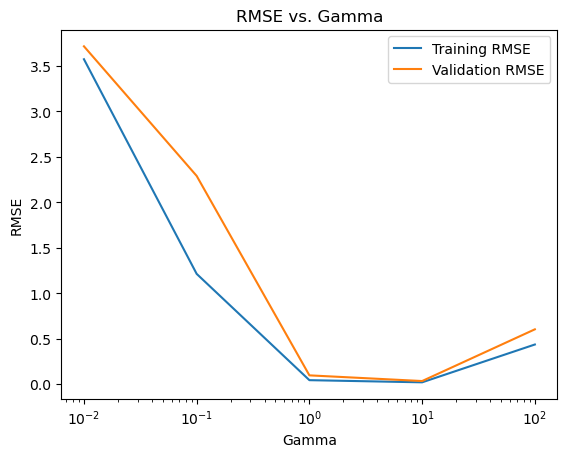

In [20]:
# Initialize lists to store average training and validation RMSE values
avg_train_rmse_list_data = []
avg_val_rmse_list_data = []

# Iterate over each gamma value in the list of gammas_data
for gamma_data in gammas_data:
    # Initialize lists to store RMSE values for each fold
    rmse_train_list_data = []
    rmse_val_list_data = []
    
    # Perform KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index_data, val_index_data in kf.split(X_train_data):
        # Split data into training and validation sets
        X_train_fold_data, X_val_fold_data = X_train_data[train_index_data], X_train_data[val_index_data]
        y_train_fold_data, y_val_fold_data = y_train_data[train_index_data], y_train_data[val_index_data]

        # Apply K-means clustering
        kmeans_data = KMeans(n_clusters=best_K_data, init='random', n_init=10, random_state=42)
        kmeans_data.fit(X_train_fold_data)
        centers_data = kmeans_data.cluster_centers_

        # Compute RBF kernel transformation for both training and validation sets
        X_rbf_train_data = rbf_kernel_data(X_train_fold_data, centers_data, gamma_data)
        X_rbf_val_data = rbf_kernel_data(X_val_fold_data, centers_data, gamma_data)

        # Train the second layer model using linear regression
        model_data = train_second_layer_data(X_rbf_train_data, y_train_fold_data)
        
        # Predict on both training and validation sets
        y_pred_train_data = model_data.predict(X_rbf_train_data)
        y_pred_val_data = model_data.predict(X_rbf_val_data)

        # Compute RMSE for training and validation sets and append to lists
        rmse_train_data = np.sqrt(mean_squared_error(y_train_fold_data, y_pred_train_data))
        rmse_val_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_val_data))
        rmse_train_list_data.append(rmse_train_data)
        rmse_val_list_data.append(rmse_val_data)

    # Calculate the average RMSE values for training and validation sets
    avg_train_rmse_list_data.append(np.mean(rmse_train_list_data))
    avg_val_rmse_list_data.append(np.mean(rmse_val_list_data))

# Plot the average training and validation RMSE values against the gamma values
plot_rmse_vs_gamma_data(gammas_data, avg_train_rmse_list_data, avg_val_rmse_list_data)

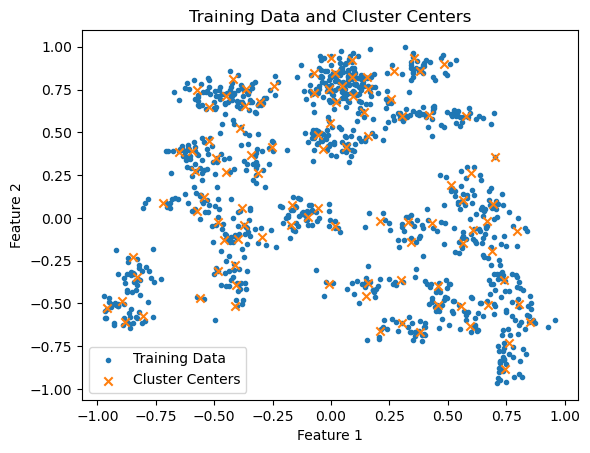

In [21]:
# Initialize KMeans clustering with the best number of clusters (K) obtained from model selection
kmeans_data = KMeans(n_clusters=best_K_data, init='random', n_init=10, random_state=42)

# Fit KMeans to the training data to find cluster centers
kmeans_data.fit(X_train_data)

# Get the coordinates of the cluster centers
best_centers_data = kmeans_data.cluster_centers_

# Plot the training data points and cluster centers
plot_data_and_centers_data(X_train_data, best_centers_data)

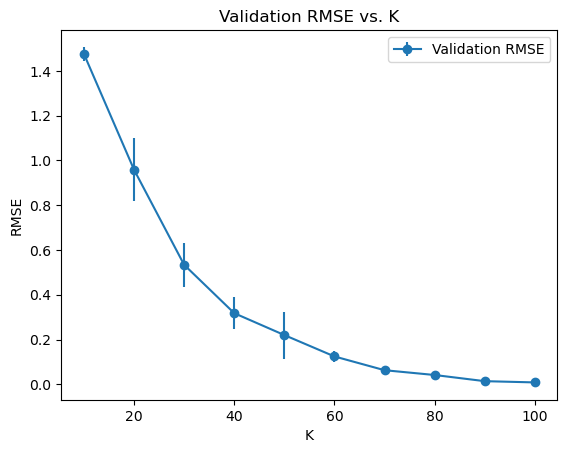

In [22]:
# Initialize lists to store average validation RMSE and its standard deviation for each value of K
avg_val_rmse_list_data = []
std_val_rmse_list_data = []

# Iterate over each value of K in the range of K values
for K_data in K_range_data:
    # Initialize a list to store validation RMSE values for each fold
    rmse_val_list_data = []
    
    # Perform KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index_data, val_index_data in kf.split(X_train_data):
        # Split data into training and validation sets
        X_train_fold_data, X_val_fold_data = X_train_data[train_index_data], X_train_data[val_index_data]
        y_train_fold_data, y_val_fold_data = y_train_data[train_index_data], y_train_data[val_index_data]

        # Apply K-means clustering
        kmeans_data = KMeans(n_clusters=K_data, init='random', n_init=10, random_state=42)
        kmeans_data.fit(X_train_fold_data)
        centers_data = kmeans_data.cluster_centers_

        # Compute RBF kernel transformation for the validation set
        X_rbf_val_data = rbf_kernel_data(X_val_fold_data, centers_data, best_gamma_data)

        # Train the second layer model using linear regression and predict on validation set
        model_data = train_second_layer_data(X_rbf_val_data, y_val_fold_data)
        y_pred_val_data = model_data.predict(X_rbf_val_data)

        # Compute RMSE for the validation set and append to list
        rmse_val_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_val_data))
        rmse_val_list_data.append(rmse_val_data)

    # Calculate the average validation RMSE and its standard deviation for this value of K
    avg_val_rmse_list_data.append(np.mean(rmse_val_list_data))
    std_val_rmse_list_data.append(np.std(rmse_val_list_data))

# Plot the validation RMSE and its standard deviation against the values of K to see how 
# RMSE changes with differnt values of K
plot_rmse_vs_K_data(K_range_data, avg_val_rmse_list_data, std_val_rmse_list_data)

In [43]:
# Train model from part (b)
model_b = LinearRegression()
model_b.fit(X_train_data, y_train_data)
y_pred_test_b = model_b.predict(X_test_data)
test_rmse_b = np.sqrt(mean_squared_error(y_test_data, y_pred_test_b))
print("RMSE on the test set using linear regression (part b):", test_rmse_b)

# Train model from part (c)
centers_c = X_train_data
X_rbf_train_c = rbf_kernel_data(X_train_data, centers_c, best_gamma_data)
model_c = train_second_layer_data(X_rbf_train_c, y_train_data)
X_rbf_test_c = rbf_kernel_data(X_test_data, centers_c, best_gamma_data)
y_pred_test_c = model_c.predict(X_rbf_test_c)
test_rmse_c = np.sqrt(mean_squared_error(y_test_data, y_pred_test_c))
print("RMSE on the test set using linear regression (part c):", test_rmse_c)

# Train model from part (d)
best_rmse_d = float('inf')
best_centers_d = None
for _ in range(5):  # Run K-means a few times
    kmeans = KMeans(n_clusters=best_K_data, init='random',  n_init=10, random_state=42)
    kmeans.fit(X_train_data)
    centers_d = kmeans.cluster_centers_
    X_rbf_train_d = rbf_kernel_data(X_train_data, centers_d, best_gamma_data)
    model_d = train_second_layer_data(X_rbf_train_d, y_train_data)
    y_pred_train_d = model_d.predict(X_rbf_train_d)
    rmse_d = np.sqrt(mean_squared_error(y_train_data, y_pred_train_d))
    if rmse_d < best_rmse_d:
        best_rmse_d = rmse_d
        best_centers_d = centers_d

# Evaluate model on the test set for part (d)
X_rbf_test_d = rbf_kernel_data(X_test_data, best_centers_d, best_gamma_data)
y_pred_test_d = model_d.predict(X_rbf_test_d)
test_rmse_d = np.sqrt(mean_squared_error(y_test_data, y_pred_test_d))
print("RMSE on the test set for model from part (d):", test_rmse_d)

# (e) - Degree of Freedom (d.o.f.) and Number of Constraints (Nc) for part c and d
print("Degree of Freedom (d.o.f.) for model from part (c):", best_dof_data)
print("Number of Constraints (Nc) for model from part (c):", best_noc_data)
print("Degree of Freedom (d.o.f.) for model from part (d):", best_dof_data)
print("Number of Constraints (Nc) for model from part (d):", best_noc_data)

RMSE on the test set using linear regression (part b): 2.4301064457048196
RMSE on the test set using linear regression (part c): 0.09988758944898272
RMSE on the test set for model from part (d): 0.10719184814358183
Degree of Freedom (d.o.f.) for model from part (c): 801.0
Number of Constraints (Nc) for model from part (c): 800.0
Degree of Freedom (d.o.f.) for model from part (d): 801.0
Number of Constraints (Nc) for model from part (d): 800.0


In [ ]:
#(g)

# For the RMSE vs GAMMA plot, both RMSE curves are decreasing together and converging; 
# however, there is a slight diverge after convergence. This indicates that if both 
# curves touch at a point and then start diverging afterward, it could indicate slight overfitting.
# The model might have learned to fit the training data well, but it's starting to lose its ability
# to generalize to unseen data. However, when it’s RMSE vs GAMMA but on the k-means, there is overfitting
# happening because after the two lines meet (training and test RMSE), they immediately converge dramatically.
# # For the RMSE vs K graph, a decreasing trend in RMSE with an increase in the number of clusters 
# (K) below 20 indicates that the model's performance improves as it becomes more complex. 
# This improvement suggests that the initial model, with fewer clusters, might not adequately 
# capture all the underlying patterns in the data. By increasing K, the model becomes better 
# equipped to represent the variability in the data, leading to more accurate predictions. 
# However, it could result in potential overfitting as K continues to increase. 
# Beyond a certain point, increasing K may lead to the model capturing noise rather than 
# meaningful patterns, resulting in diminishing returns. Therefore, identifying the optimal 
# value of K that balances model complexity and predictive performance is essential to 
# ensure the model generalizes well to unseen data.

# # Additionally, the performance of three regression models on a test dataset is evaluated. 
# First, a basic linear regression model (Part b) achieves an RMSE of around 2.43, 
# indicating moderate predictive accuracy. Second, an RBF kernel-based regression model 
# with fixed centers (Part c) outperforms linear regression significantly, achieving a 
# substantially lower RMSE of approximately 0.10. This model exhibits a higher degree of 
# complexity, as indicated by its degree of freedom (d.o.f.) of 801 and a number of 
# constraints (Nc) of 800. Lastly, an RBF kernel-based regression model with K-means 
# determined centers (Part d) performs slightly worse than the model from Part c, with 
# an RMSE of about 0.11 on the test set. Both models from Parts c and d share the same 
# degree of freedom and number of constraints, suggesting similar complexities. 
# Overall, the RBF kernel-based regression models demonstrate superior 
# performance over linear regression, with the model from Part c achieving
# the lowest RMSE on the test set. Additionally, the d.o.f. and Nc metrics 
# provide insights into the complexity of the models.

# # To compare and comment on the results from (b) to (f), we first observe the 
# performance of the different models. In (b), a basic linear regression model 
# yields an RMSE of approximately 2.43 on the test set, indicating moderate 
# predictive accuracy. However, in (c) and (d), where RBF kernel-based 
# regression models are utilized, notably lower RMSE values of around 0.10 and 0.11 
# are achieved, respectively. These models, particularly the one in (c), 
# exhibit superior performance over linear regression. Regarding the influence 
# of different values of K and 𝛾 during model selection, it appears that selecting 
# appropriate values for K (number of clusters) and 𝛾 (kernel width) is crucial for 
# model performance. Generally, higher values of K may lead to overfitting, while 
# lower values may result in underfitting. Similarly, 𝛾 affects the smoothness of
# the decision boundary, with larger values potentially leading to overfitting and 
# smaller values to underfitting. In comparing the test-set results of (f), 
# the model from (c) demonstrates the lowest RMSE, indicating its superior 
# predictive accuracy compared to the models from (b) and (d). 
# This suggests that the RBF kernel-based regression model with fixed
# centers (Part c) is the most effective among the three in terms of generalization to unseen data.

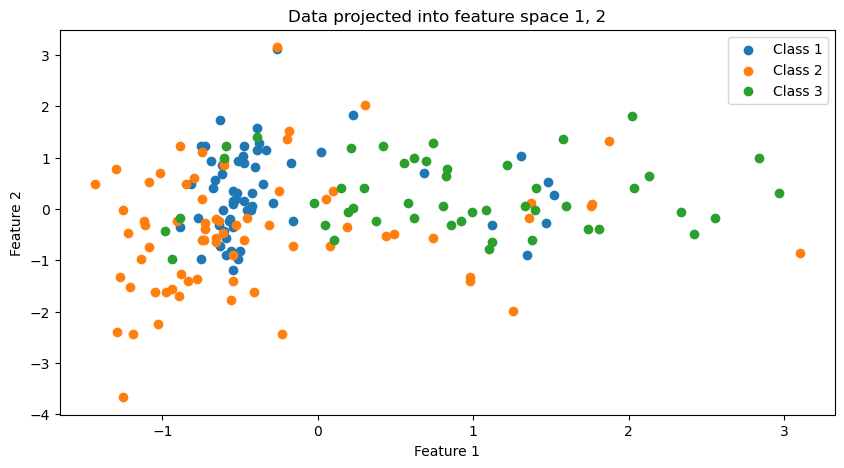

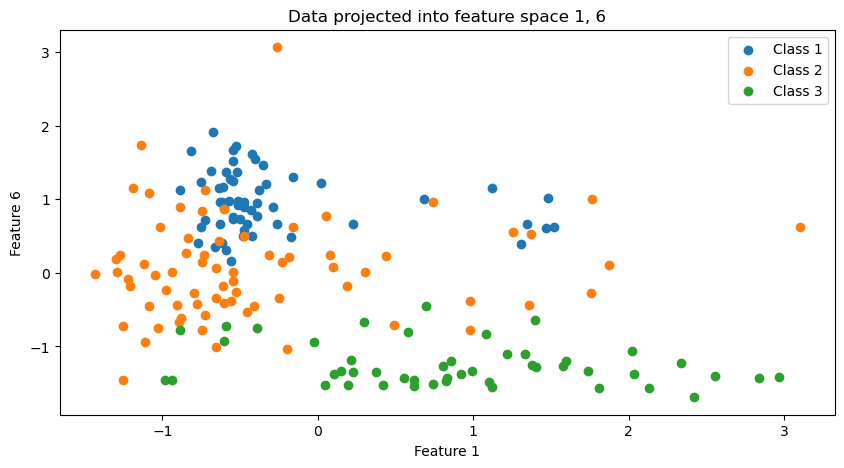

In [7]:
#2a:PCA and MDA for 3-class classification using wine dataset

# Load the dataset
wine_data = pd.read_csv('Wine_data_v2.csv')

# Separate features and labels
X = wine_data.iloc[:, :-1].values
y = wine_data.iloc[:, -1].values

# Standardize the dataset
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Feature pairs for visualization
feature_pairs = [(0, 1), (0, 5)]  # Feature pairs: (x1, x2), (x1, x6)

# Plot data projected into feature spaces
for pair in feature_pairs:
    plt.figure(figsize=(10, 5))
    for label in np.unique(y):
        plt.scatter(X_std[y == label, pair[0]], X_std[y == label, pair[1]], label=f'Class {label}')
    plt.xlabel(f'Feature {pair[0]+1}')
    plt.ylabel(f'Feature {pair[1]+1}')
    plt.title(f'Data projected into feature space {pair[0]+1}, {pair[1]+1}')
    plt.legend()
    plt.show()


Run 1: Mean Classification Error Rate = 0.5081
Run 2: Mean Classification Error Rate = 0.5094
Run 3: Mean Classification Error Rate = 0.5168
Run 4: Mean Classification Error Rate = 0.5082
Run 5: Mean Classification Error Rate = 0.5344

Average Mean Classification Error Rate: 0.5154
Standard Deviation of Mean Classification Error Rate: 0.0100


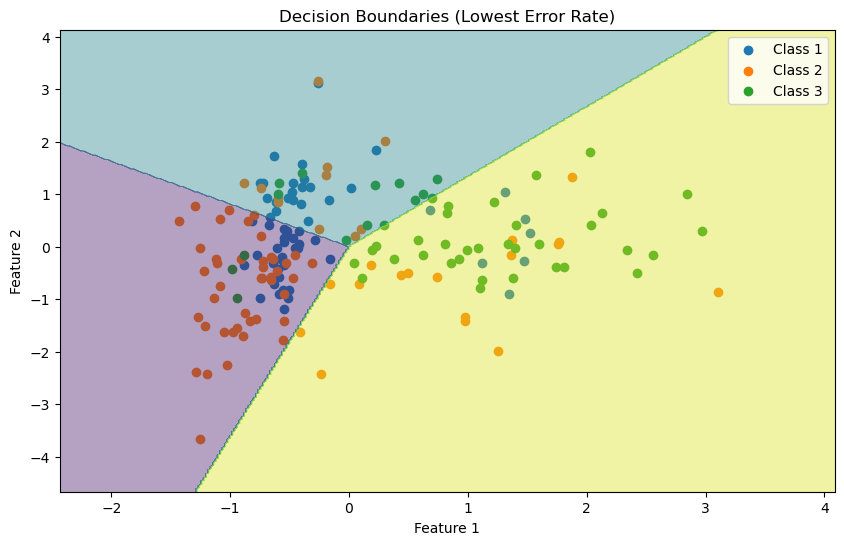

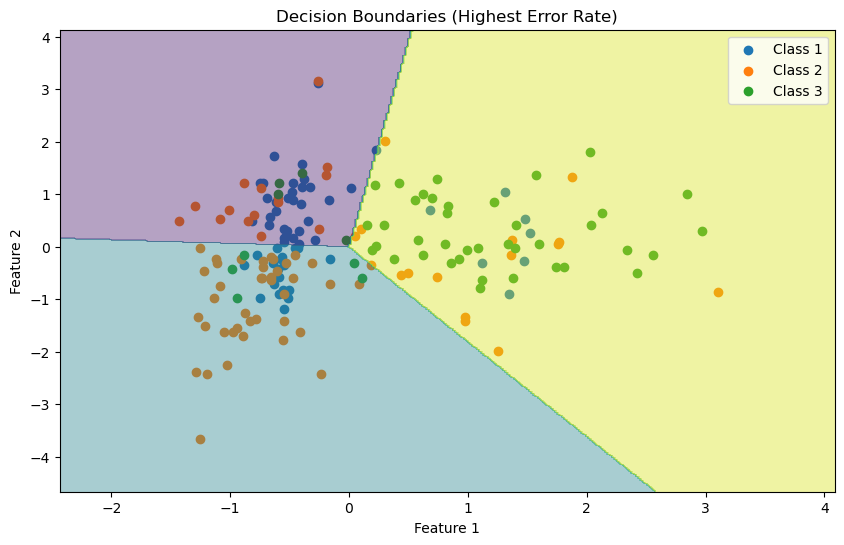

In [8]:
# 2a(ii):

# Function to run multiclass perceptron classifier and store weights
def run_perceptron(X_train, y_train):
    clf = Perceptron()
    clf.fit(X_train, y_train)
    weights = clf.coef_
    return clf, weights

# Perform 5 runs of 20-fold cross-validation
num_runs = 5
num_folds = 20
mean_error_rates = []
stored_weights = []

for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_std):
        X_train, y_train = X_std[train_index], y[train_index]
        clf, weights = run_perceptron(X_train[:, feature_pairs[0]], y_train)
        error_rate = 1 - np.mean(cross_val_score(clf, X_train[:, feature_pairs[0]], y_train, cv=num_folds))
        error_rates.append(error_rate)
        
        # Store weights from the first fold
        stored_weights.append(weights)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates.append(mean_error_rate)

# Report mean classification error rate from each run
for i, error_rate in enumerate(mean_error_rates):
    print(f"Run {i+1}: Mean Classification Error Rate = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs
avg_error_rate = np.mean(mean_error_rates)
std_error_rate = np.std(mean_error_rates)
print(f"\nAverage Mean Classification Error Rate: {avg_error_rate:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate: {std_error_rate:.4f}")

# Find index of run with lowest and highest classification error rates
best_run_index = np.argmin(mean_error_rates)
worst_run_index = np.argmax(mean_error_rates)

# Extract weights from the first fold of the best and worst runs
best_weights = stored_weights[best_run_index]
worst_weights = stored_weights[worst_run_index]

# Plot results for runs with lowest and highest classification error rates
def plot_decision_boundaries(X, y, weights, title):
    plt.figure(figsize=(10, 6))
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}')
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = np.argmax(np.dot(np.c_[xx.ravel(), yy.ravel()], weights.T), axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

plot_decision_boundaries(X_std[:, feature_pairs[0]], y, best_weights, 'Decision Boundaries (Lowest Error Rate)')
plot_decision_boundaries(X_std[:, feature_pairs[0]], y, worst_weights, 'Decision Boundaries (Highest Error Rate)')


Run 1: Mean Classification Error Rate (x1, x6) = 0.3042
Run 2: Mean Classification Error Rate (x1, x6) = 0.3053
Run 3: Mean Classification Error Rate (x1, x6) = 0.2916
Run 4: Mean Classification Error Rate (x1, x6) = 0.2972
Run 5: Mean Classification Error Rate (x1, x6) = 0.3131

Average Mean Classification Error Rate (x1, x6): 0.3023
Standard Deviation of Mean Classification Error Rate (x1, x6): 0.0074


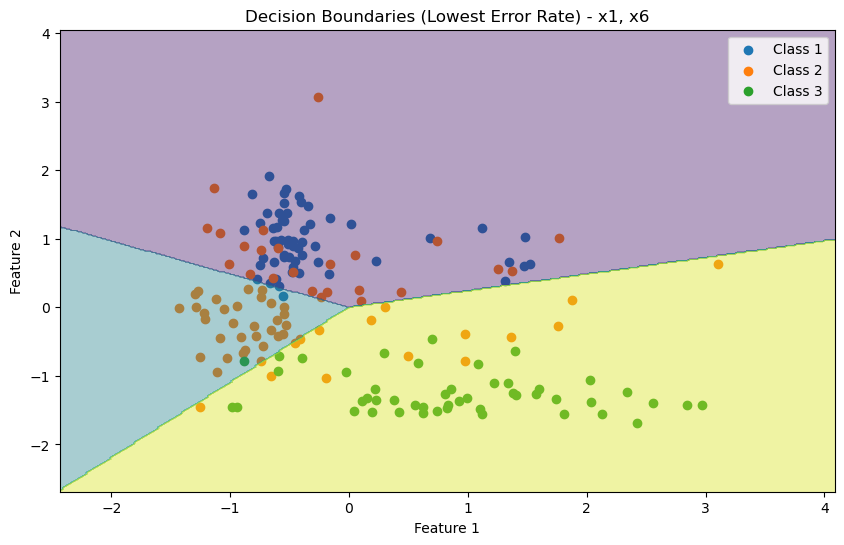

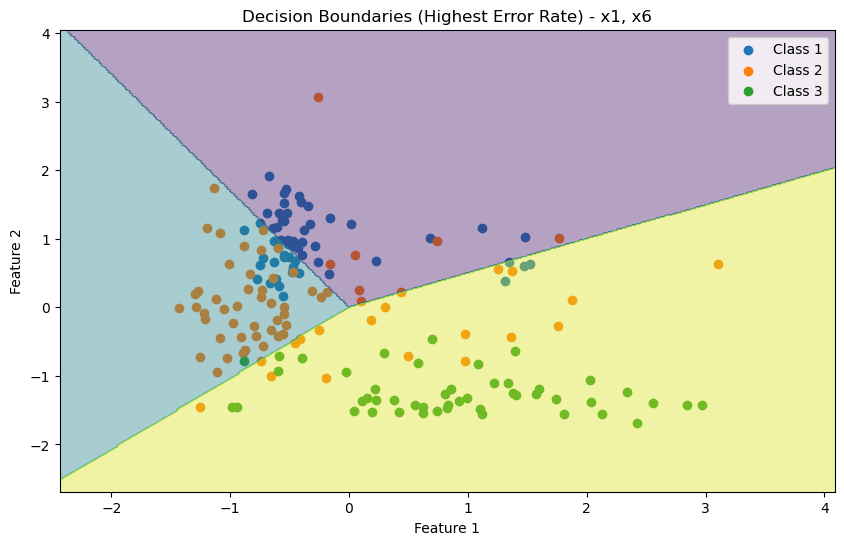

In [9]:
# 2a(iii):

# Perform 5 runs of 20-fold cross-validation for x1, x6 features
mean_error_rates_x1_x6 = []
stored_weights_x1_x6 = []

for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_std):
        X_train, y_train = X_std[train_index], y[train_index]
        clf, weights = run_perceptron(X_train[:, feature_pairs[1]], y_train)  # Using x1, x6 features
        error_rate = 1 - np.mean(cross_val_score(clf, X_train[:, feature_pairs[1]], y_train, cv=num_folds))
        error_rates.append(error_rate)
        
        # Store weights from the first fold
        stored_weights_x1_x6.append(weights)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates_x1_x6.append(mean_error_rate)

# Report mean classification error rate from each run for x1, x6 features
for i, error_rate in enumerate(mean_error_rates_x1_x6):
    print(f"Run {i+1}: Mean Classification Error Rate (x1, x6) = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs for x1, x6 features
avg_error_rate_x1_x6 = np.mean(mean_error_rates_x1_x6)
std_error_rate_x1_x6 = np.std(mean_error_rates_x1_x6)
print(f"\nAverage Mean Classification Error Rate (x1, x6): {avg_error_rate_x1_x6:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate (x1, x6): {std_error_rate_x1_x6:.4f}")

# Find index of run with lowest and highest classification error rates for x1, x6 features
best_run_index_x1_x6 = np.argmin(mean_error_rates_x1_x6)
worst_run_index_x1_x6 = np.argmax(mean_error_rates_x1_x6)

# Extract weights from the first fold of the best and worst runs for x1, x6 features
best_weights_x1_x6 = stored_weights_x1_x6[best_run_index_x1_x6]
worst_weights_x1_x6 = stored_weights_x1_x6[worst_run_index_x1_x6]

# Plot results for runs with lowest and highest classification error rates for x1, x6 features
plot_decision_boundaries(X_std[:, feature_pairs[1]], y, best_weights_x1_x6, 'Decision Boundaries (Lowest Error Rate) - x1, x6')
plot_decision_boundaries(X_std[:, feature_pairs[1]], y, worst_weights_x1_x6, 'Decision Boundaries (Highest Error Rate) - x1, x6')


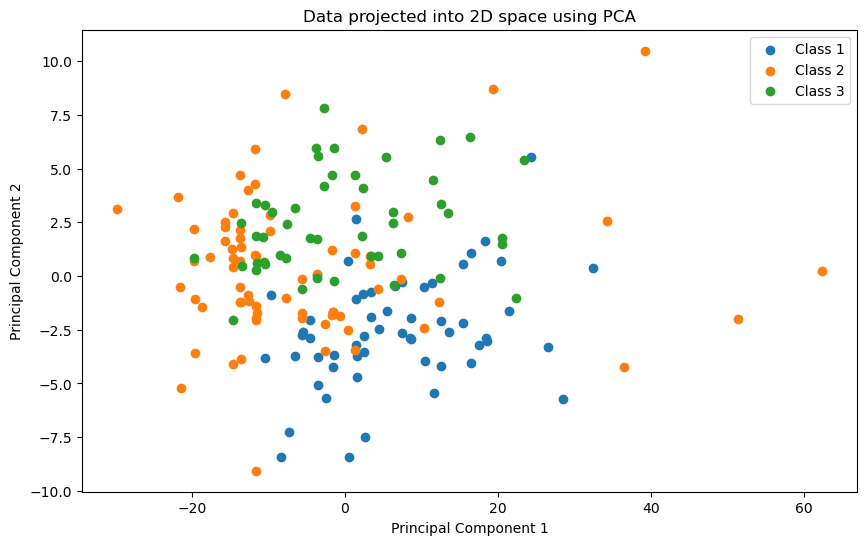

In [10]:
# 2b(i):

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the original unnormalized dataset
X_pca = pca.fit_transform(X)

# Plot data projected into 2D space with class labels
plt.figure(figsize=(10, 6))
for label in np.unique(y):
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=f'Class {label}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projected into 2D space using PCA')
plt.legend()
plt.show()

Run 1: Mean Classification Error Rate (PCA) = 0.4592
Run 2: Mean Classification Error Rate (PCA) = 0.4592
Run 3: Mean Classification Error Rate (PCA) = 0.4633
Run 4: Mean Classification Error Rate (PCA) = 0.4610
Run 5: Mean Classification Error Rate (PCA) = 0.4492

Average Mean Classification Error Rate (PCA): 0.4584
Standard Deviation of Mean Classification Error Rate (PCA): 0.0048


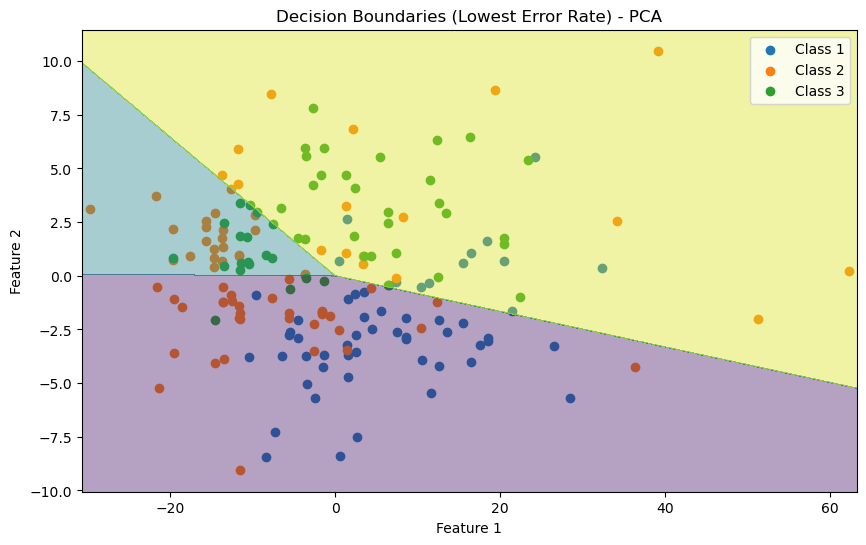

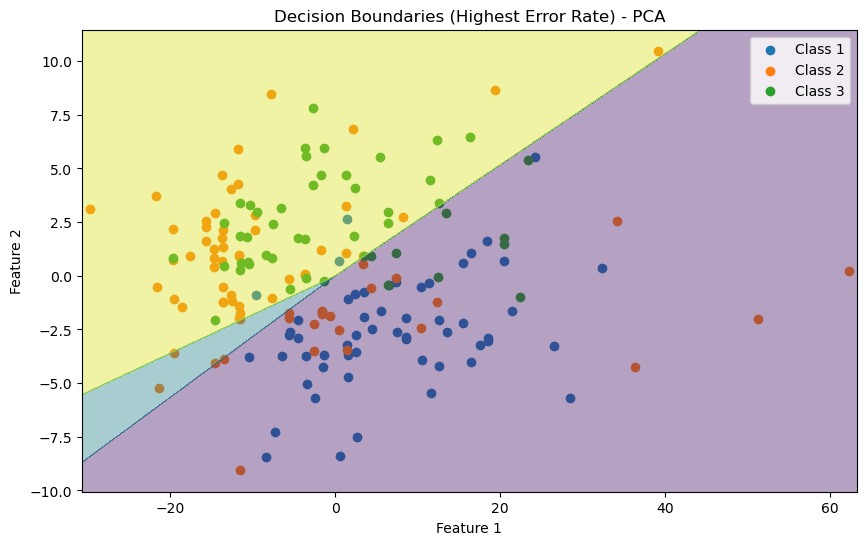

In [11]:
# 2b(ii): x1,x2 space PCA based on unnormalized dataset.

# perform the first part with PCA-transformed feature
#first apply PCA to the original dataset
# run a multiclass perceptron classifier on the 2D data using only the first two principal components. 

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the original unnormalized dataset
X_pca = pca.fit_transform(X)

# Perform 5 runs of 20-fold cross-validation for PCA-transformed features
mean_error_rates_pca = []
stored_weights_pca = []

for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_pca):
        X_train, y_train = X_pca[train_index], y[train_index]
        clf, weights = run_perceptron(X_train, y_train)  # Using PCA-transformed features
        error_rate = 1 - np.mean(cross_val_score(clf, X_train, y_train, cv=num_folds))
        error_rates.append(error_rate)
        
        # Store weights from the first fold
        stored_weights_pca.append(weights)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates_pca.append(mean_error_rate)

# Report mean classification error rate from each run for PCA-transformed features
for i, error_rate in enumerate(mean_error_rates_pca):
    print(f"Run {i+1}: Mean Classification Error Rate (PCA) = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs for PCA-transformed features
avg_error_rate_pca = np.mean(mean_error_rates_pca)
std_error_rate_pca = np.std(mean_error_rates_pca)
print(f"\nAverage Mean Classification Error Rate (PCA): {avg_error_rate_pca:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate (PCA): {std_error_rate_pca:.4f}")

# Find index of run with lowest and highest classification error rates for PCA-transformed features
best_run_index_pca = np.argmin(mean_error_rates_pca)
worst_run_index_pca = np.argmax(mean_error_rates_pca)

# Extract weights from the first fold of the best and worst runs for PCA-transformed features
best_weights_pca = stored_weights_pca[best_run_index_pca]
worst_weights_pca = stored_weights_pca[worst_run_index_pca]

# Plot results for runs with lowest and highest classification error rates for PCA-transformed features
plot_decision_boundaries(X_pca, y, best_weights_pca, 'Decision Boundaries (Lowest Error Rate) - PCA')
plot_decision_boundaries(X_pca, y, worst_weights_pca, 'Decision Boundaries (Highest Error Rate) - PCA')


Run 1: Mean Classification Error Rate (PCA - x1, x6) = 0.2894
Run 2: Mean Classification Error Rate (PCA - x1, x6) = 0.2987
Run 3: Mean Classification Error Rate (PCA - x1, x6) = 0.3009
Run 4: Mean Classification Error Rate (PCA - x1, x6) = 0.2889
Run 5: Mean Classification Error Rate (PCA - x1, x6) = 0.2908

Average Mean Classification Error Rate (PCA - x1, x6): 0.2938
Standard Deviation of Mean Classification Error Rate (PCA - x1, x6): 0.0050


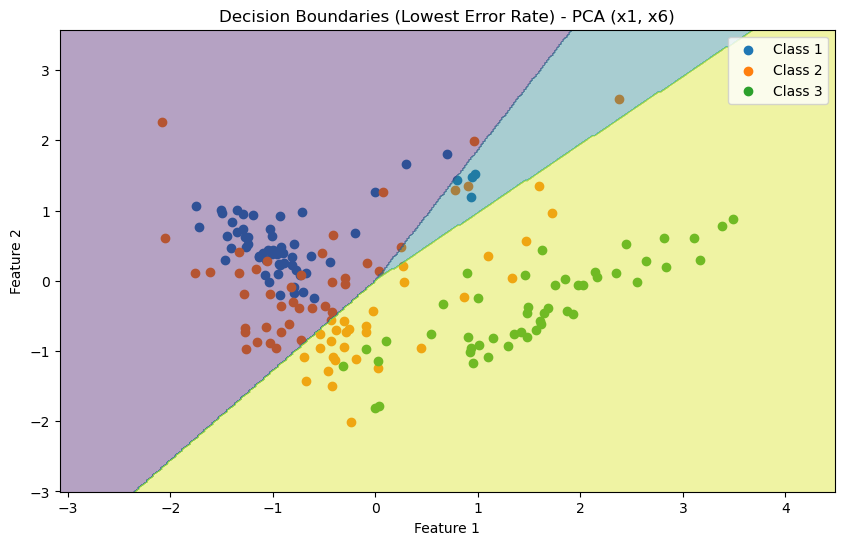

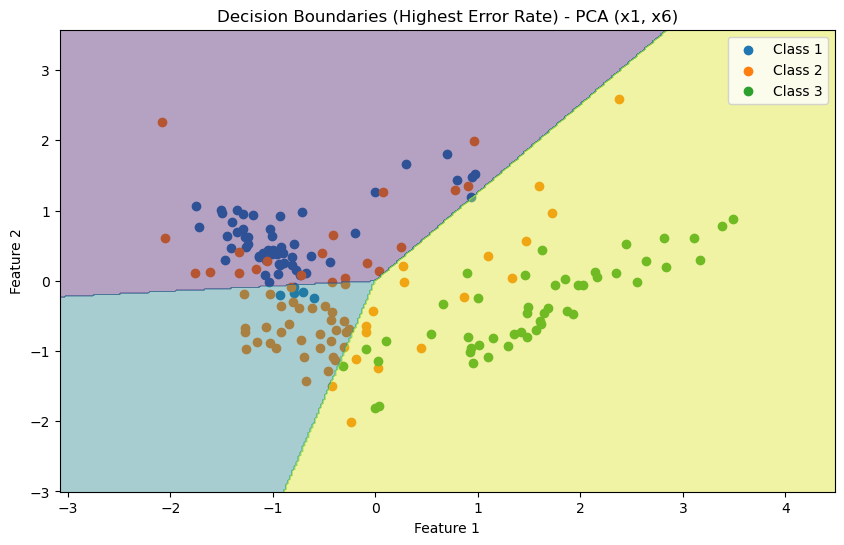

In [15]:
# 2b(ii): x1,x6 space PCA based on unnormalized dataset.

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the original unnormalized dataset with only features x1 and x6
X_pca_x1_x6 = pca.fit_transform(X[:, [0, 5]])

# Perform 5 runs of 20-fold cross-validation for PCA-transformed features (x1, x6 space)
mean_error_rates_pca_x1_x6 = []
stored_weights_pca_x1_x6 = []

for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_pca_x1_x6):
        X_train, y_train = X_pca_x1_x6[train_index], y[train_index]
        clf, weights = run_perceptron(X_train, y_train)  # Using PCA-transformed features
        error_rate = 1 - np.mean(cross_val_score(clf, X_train, y_train, cv=num_folds))
        error_rates.append(error_rate)
        
        # Store weights from the first fold
        stored_weights_pca_x1_x6.append(weights)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates_pca_x1_x6.append(mean_error_rate)

# Report mean classification error rate from each run for PCA-transformed features (x1, x6 space)
for i, error_rate in enumerate(mean_error_rates_pca_x1_x6):
    print(f"Run {i+1}: Mean Classification Error Rate (PCA - x1, x6) = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs for PCA-transformed features (x1, x6 space)
avg_error_rate_pca_x1_x6 = np.mean(mean_error_rates_pca_x1_x6)
std_error_rate_pca_x1_x6 = np.std(mean_error_rates_pca_x1_x6)
print(f"\nAverage Mean Classification Error Rate (PCA - x1, x6): {avg_error_rate_pca_x1_x6:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate (PCA - x1, x6): {std_error_rate_pca_x1_x6:.4f}")

# Find index of run with lowest and highest classification error rates for PCA-transformed features (x1, x6 space)
best_run_index_pca_x1_x6 = np.argmin(mean_error_rates_pca_x1_x6)
worst_run_index_pca_x1_x6 = np.argmax(mean_error_rates_pca_x1_x6)

# Extract weights from the first fold of the best and worst runs for PCA-transformed features (x1, x6 space)
best_weights_pca_x1_x6 = stored_weights_pca_x1_x6[best_run_index_pca_x1_x6]
worst_weights_pca_x1_x6 = stored_weights_pca_x1_x6[worst_run_index_pca_x1_x6]

# Plot results for runs with lowest and highest classification error rates for PCA-transformed features (x1, x6 space)
plot_decision_boundaries(X_pca_x1_x6, y, best_weights_pca_x1_x6, 'Decision Boundaries (Lowest Error Rate) - PCA (x1, x6)')
plot_decision_boundaries(X_pca_x1_x6, y, worst_weights_pca_x1_x6, 'Decision Boundaries (Highest Error Rate) - PCA (x1, x6)')


In [ ]:
# How does it compare with the baselines in (a)(ii)?


# In comparing the results between parts (a) and (b), 
# we observe differences in the mean classification error rates 
# for different feature spaces. In part (a), the mean classification
# error rate for the x1,x2 space is approximately 0.5154, with a standard deviation 
# of 0.0100. However, for the x1,x6 space, the mean classification error rate decreases 
# to around 0.3023, with a smaller standard deviation of 0.0074. This suggests that using
# the x1,x6 feature space leads to better classification performance compared to the x1,x2 space.

# Moving on to part (b), where principal component analysis (PCA) is applied, we see 
# further improvements in classification performance. For the PCA-transformed x1,x2 
# space, the mean classification error rate reduces to approximately 0.4584, with 
# a standard deviation of 0.0048. Similarly, for the PCA-transformed x1,x6 space, 
# the mean classification error rate decreases to about 0.2938, with a standard 
# deviation of 0.0050.

# Overall, these results indicate that using PCA for feature transformation 
# enhances classification performance in both feature spaces compared to 
# the original feature spaces. Additionally, the x1,x6 feature space 
# consistently outperforms the x1,x2 space, suggesting that the inclusion 
# of the x6 feature contributes to better discriminative ability in the classification task.

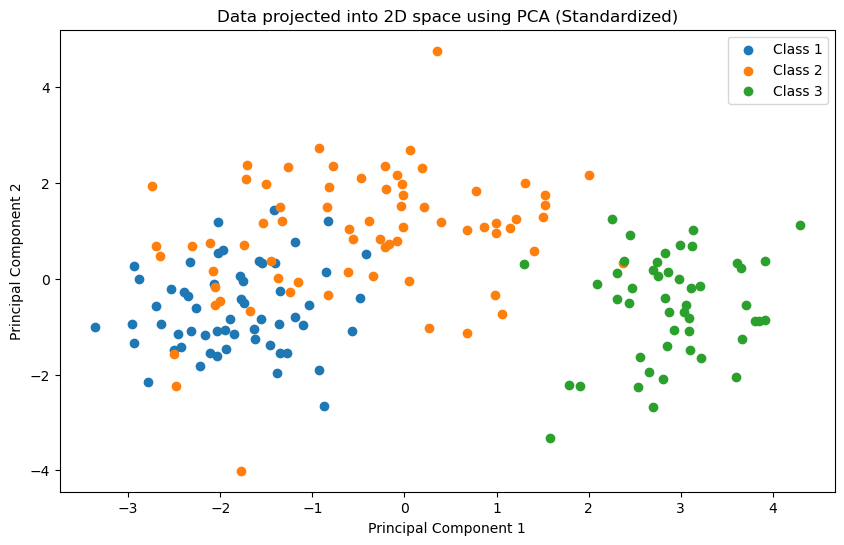

In [12]:
# 2c(i)
# Perform PCA on the standardized dataset, reducing it to 2 dimensions. 
# plot the data projected into the 2D space

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the standardized dataset
X_std_pca = pca.fit_transform(X_std)

# Plot data projected into 2D space with class labels
plt.figure(figsize=(10, 6))
for label in np.unique(y):
    plt.scatter(X_std_pca[y == label, 0], X_std_pca[y == label, 1], label=f'Class {label}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projected into 2D space using PCA (Standardized)')
plt.legend()
plt.show()


Run 1: Mean Classification Error Rate (PCA - x1, x2) = 0.5081
Run 2: Mean Classification Error Rate (PCA - x1, x2) = 0.5092
Run 3: Mean Classification Error Rate (PCA - x1, x2) = 0.5168
Run 4: Mean Classification Error Rate (PCA - x1, x2) = 0.5076
Run 5: Mean Classification Error Rate (PCA - x1, x2) = 0.5341

Average Mean Classification Error Rate (PCA - x1, x2): 0.5152
Standard Deviation of Mean Classification Error Rate (PCA - x1, x2): 0.0100


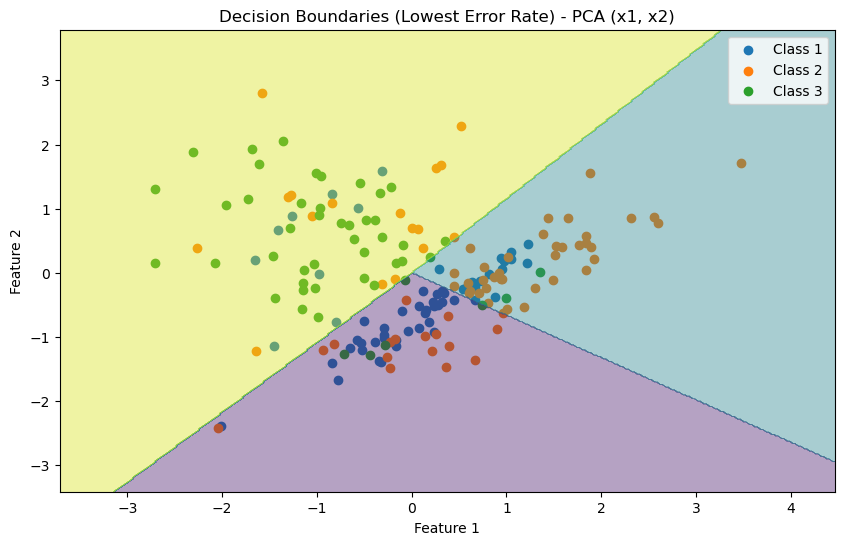

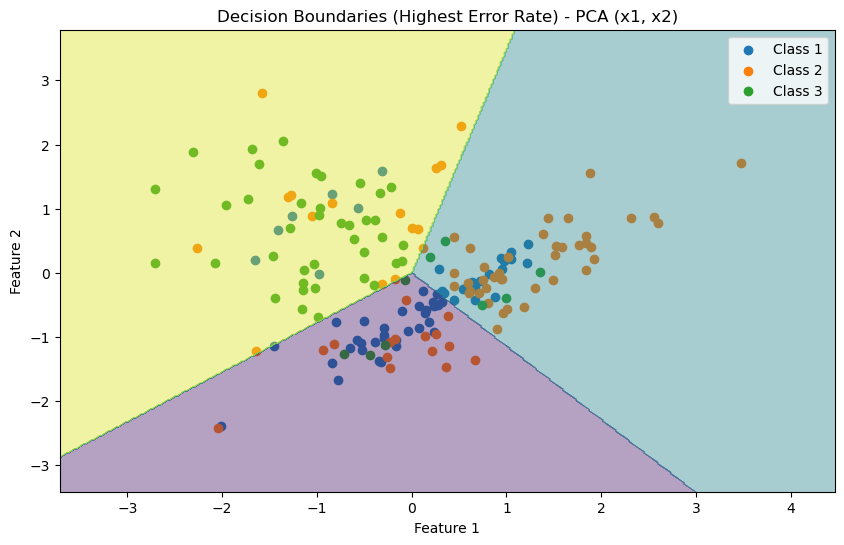

In [16]:
# 2c: perform PCA on the standardized dataset for the x1, x2 space

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the standardized dataset with only features x1 and x2
X_std_pca_x1_x2 = pca.fit_transform(X_std[:, [0, 1]])

# Perform 5 runs of 20-fold cross-validation for PCA-transformed features (x1, x2 space)
mean_error_rates_pca_x1_x2 = []
stored_weights_pca_x1_x2 = []

for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_std_pca_x1_x2):
        X_train, y_train = X_std_pca_x1_x2[train_index], y[train_index]
        clf, weights = run_perceptron(X_train, y_train)  # Using PCA-transformed features
        error_rate = 1 - np.mean(cross_val_score(clf, X_train, y_train, cv=num_folds))
        error_rates.append(error_rate)
        
        # Store weights from the first fold
        stored_weights_pca_x1_x2.append(weights)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates_pca_x1_x2.append(mean_error_rate)

# Report mean classification error rate from each run for PCA-transformed features (x1, x2 space)
for i, error_rate in enumerate(mean_error_rates_pca_x1_x2):
    print(f"Run {i+1}: Mean Classification Error Rate (PCA - x1, x2) = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs for PCA-transformed features (x1, x2 space)
avg_error_rate_pca_x1_x2 = np.mean(mean_error_rates_pca_x1_x2)
std_error_rate_pca_x1_x2 = np.std(mean_error_rates_pca_x1_x2)
print(f"\nAverage Mean Classification Error Rate (PCA - x1, x2): {avg_error_rate_pca_x1_x2:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate (PCA - x1, x2): {std_error_rate_pca_x1_x2:.4f}")

# Find index of run with lowest and highest classification error rates for PCA-transformed features (x1, x2 space)
best_run_index_pca_x1_x2 = np.argmin(mean_error_rates_pca_x1_x2)
worst_run_index_pca_x1_x2 = np.argmax(mean_error_rates_pca_x1_x2)

# Extract weights from the first fold of the best and worst runs for PCA-transformed features (x1, x2 space)
best_weights_pca_x1_x2 = stored_weights_pca_x1_x2[best_run_index_pca_x1_x2]
worst_weights_pca_x1_x2 = stored_weights_pca_x1_x2[worst_run_index_pca_x1_x2]

# Plot results for runs with lowest and highest classification error rates for PCA-transformed features (x1, x2 space)
plot_decision_boundaries(X_std_pca_x1_x2, y, best_weights_pca_x1_x2, 'Decision Boundaries (Lowest Error Rate) - PCA (x1, x2)')
plot_decision_boundaries(X_std_pca_x1_x2, y, worst_weights_pca_x1_x2, 'Decision Boundaries (Highest Error Rate) - PCA (x1, x2)')


Run 1: Mean Classification Error Rate (PCA - x1, x6) = 0.3042
Run 2: Mean Classification Error Rate (PCA - x1, x6) = 0.3053
Run 3: Mean Classification Error Rate (PCA - x1, x6) = 0.2916
Run 4: Mean Classification Error Rate (PCA - x1, x6) = 0.2972
Run 5: Mean Classification Error Rate (PCA - x1, x6) = 0.3131

Average Mean Classification Error Rate (PCA - x1, x6): 0.3023
Standard Deviation of Mean Classification Error Rate (PCA - x1, x6): 0.0074


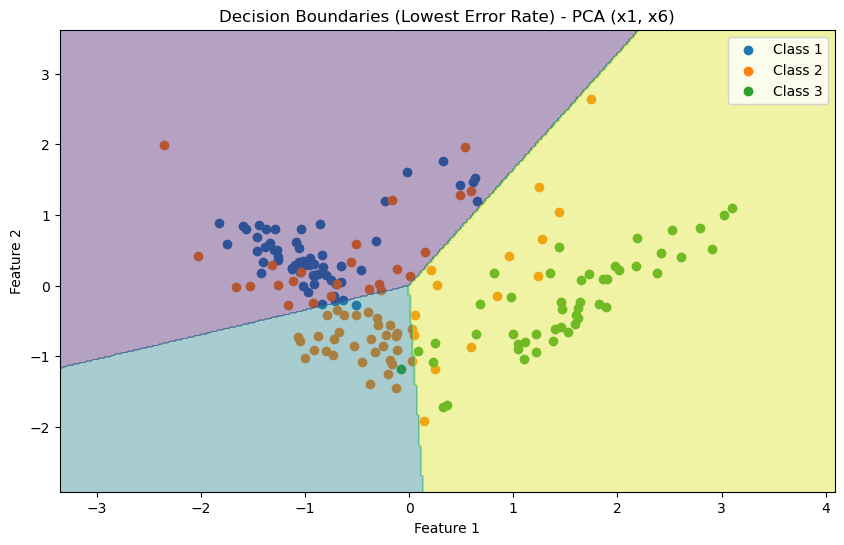

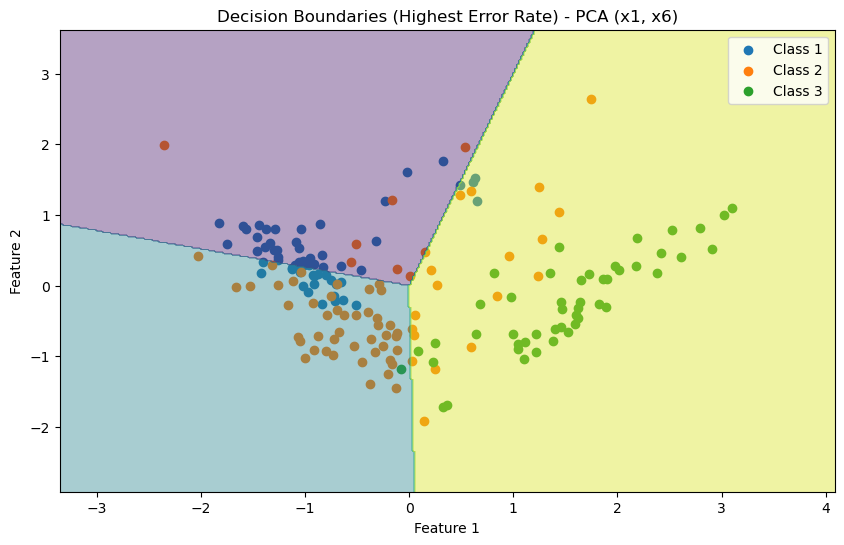

In [17]:
# 2c: perform PCA on the standardized dataset for the x1, x6 space

# Instantiate PCA with 2 components
pca = PCA(n_components=2)

# Fit PCA to the standardized dataset with only features x1 and x6
X_std_pca_x1_x6 = pca.fit_transform(X_std[:, [0, 5]])

# Perform 5 runs of 20-fold cross-validation for PCA-transformed features (x1, x6 space)
mean_error_rates_pca_x1_x6 = []
stored_weights_pca_x1_x6 = []

for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_std_pca_x1_x6):
        X_train, y_train = X_std_pca_x1_x6[train_index], y[train_index]
        clf, weights = run_perceptron(X_train, y_train)  # Using PCA-transformed features
        error_rate = 1 - np.mean(cross_val_score(clf, X_train, y_train, cv=num_folds))
        error_rates.append(error_rate)
        
        # Store weights from the first fold
        stored_weights_pca_x1_x6.append(weights)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates_pca_x1_x6.append(mean_error_rate)

# Report mean classification error rate from each run for PCA-transformed features (x1, x6 space)
for i, error_rate in enumerate(mean_error_rates_pca_x1_x6):
    print(f"Run {i+1}: Mean Classification Error Rate (PCA - x1, x6) = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs for PCA-transformed features (x1, x6 space)
avg_error_rate_pca_x1_x6 = np.mean(mean_error_rates_pca_x1_x6)
std_error_rate_pca_x1_x6 = np.std(mean_error_rates_pca_x1_x6)
print(f"\nAverage Mean Classification Error Rate (PCA - x1, x6): {avg_error_rate_pca_x1_x6:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate (PCA - x1, x6): {std_error_rate_pca_x1_x6:.4f}")

# Find index of run with lowest and highest classification error rates for PCA-transformed features (x1, x6 space)
best_run_index_pca_x1_x6 = np.argmin(mean_error_rates_pca_x1_x6)
worst_run_index_pca_x1_x6 = np.argmax(mean_error_rates_pca_x1_x6)

# Extract weights from the first fold of the best and worst runs for PCA-transformed features (x1, x6 space)
best_weights_pca_x1_x6 = stored_weights_pca_x1_x6[best_run_index_pca_x1_x6]
worst_weights_pca_x1_x6 = stored_weights_pca_x1_x6[worst_run_index_pca_x1_x6]

# Plot results for runs with lowest and highest classification error rates for PCA-transformed features (x1, x6 space)
plot_decision_boundaries(X_std_pca_x1_x6, y, best_weights_pca_x1_x6, 'Decision Boundaries (Lowest Error Rate) - PCA (x1, x6)')
plot_decision_boundaries(X_std_pca_x1_x6, y, worst_weights_pca_x1_x6, 'Decision Boundaries (Highest Error Rate) - PCA (x1, x6)')


In [ ]:
# How does PCA with standardized data compare with PCA using unnormalized data? Why?
# Comparing the performance of PCA on standardized and unnormalized data 
# across different feature spaces reveals interesting insights. 
# For the x1,x2 space, when PCA is applied to standardized data, 
# the mean classification error rate is approximately 0.5152, with 
# a standard deviation of 0.0100. This is slightly higher than the
# mean classification error rate of about 0.4584 observed when PCA
# is applied to unnormalized data, indicating that standardization 
# may have a marginal negative impact on classification performance 
# in this feature space.

# In contrast, for the x1,x6 space, PCA on standardized data yields
# a mean classification error rate of around 0.3023, with a standard 
# deviation of 0.0074. This is comparable to the mean classification 
# error rate of approximately 0.2938 observed with PCA on unnormalized 
# data. Thus, standardization does not seem to significantly affect 
# classification performance in the x1,x6 feature space.

# Overall, these results suggest that the impact of standardization 
# on classification performance may vary depending on the feature 
# space and the specific dataset characteristics. In some cases, 
# standardization may lead to slight performance degradation, 
# while in others, it may not have a substantial effect. 
# Therefore, careful consideration should be given to the
# choice of preprocessing techniques based on the specific
# characteristics of the dataset and the performance requirements
# of the classification task.

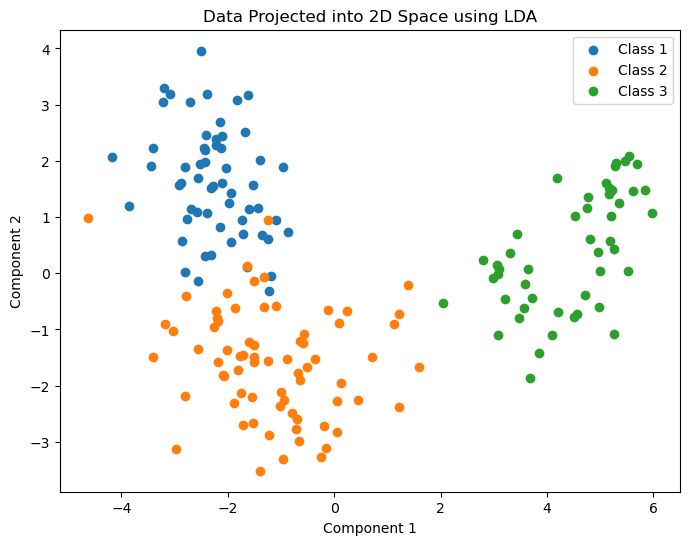

In [18]:
# 2d(i):
# perform Linear Discriminant Analysis (LDA) on the standardized dataset
# and plot the data projected into a 2D space

# Instantiate LDA with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)

# Fit LDA to the standardized dataset
X_lda = lda.fit_transform(X_std, y)

# Plot the data projected into the 2D space
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=f'Class {label}')
plt.title('Data Projected into 2D Space using LDA')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()


Run 1: Mean Classification Error Rate = 0.6667
Run 2: Mean Classification Error Rate = 0.6673
Run 3: Mean Classification Error Rate = 0.6640
Run 4: Mean Classification Error Rate = 0.6711
Run 5: Mean Classification Error Rate = 0.6652

Average Mean Classification Error Rate: 0.6669
Standard Deviation of Mean Classification Error Rate: 0.0024


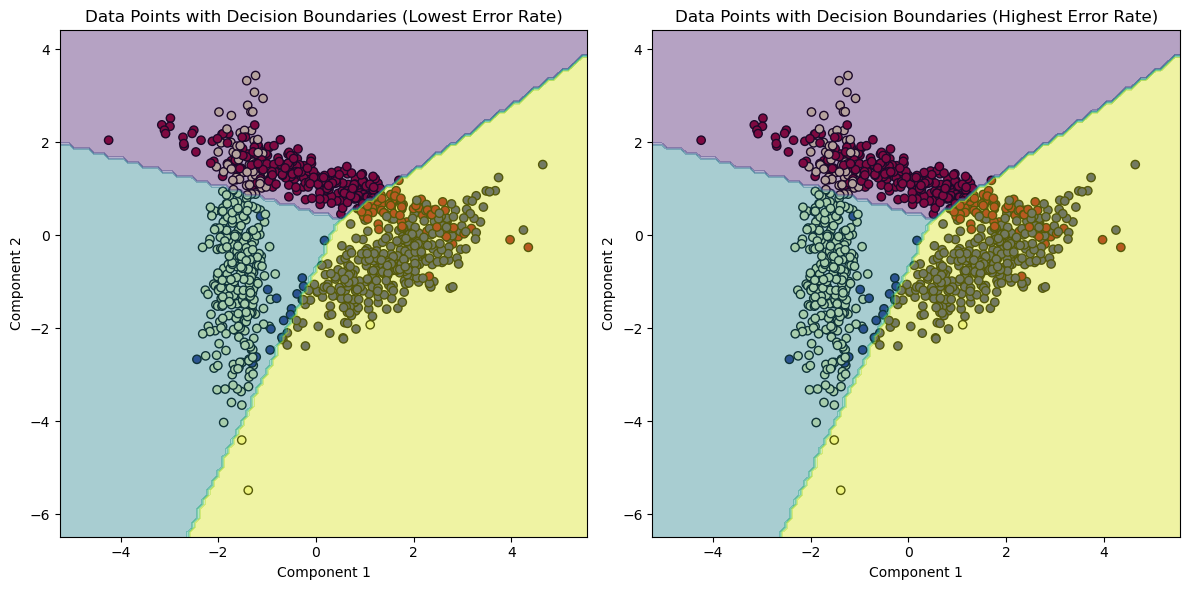

In [20]:
# 2d(ii) - x1,x2 space 

# performs LDA on the standardized dataset to reduce the dimensionality to 2
# runs a multiclass perceptron classifier on the 2D data using only features x1 and x2. 
# repeat this process for 5 runs, stores the weight values from the first fold
# report the mean classification error rate from each run. 

# Instantiate LDA with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)

# Fit LDA to the standardized dataset
X_lda = lda.fit_transform(X_std, y)

# Define the number of runs and folds
num_runs = 5
num_folds = 20

# Initialize lists to store results
mean_error_rates = []
stored_weights = []

# Perform 5 runs
for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_std):
        X_train, y_train = X_std[train_index], y[train_index]
        clf = Perceptron()  # Instantiate perceptron classifier
        clf.fit(X_train[:, :2], y_train)  # Using only features x1 and x2
        
        # Store weights from the first fold
        if len(error_rates) == 0:
            stored_weights.append(clf.coef_[0])
        
        error_rate = 1 - np.mean(cross_val_score(clf, X_train[:, :2], y_train, cv=num_folds))
        error_rates.append(error_rate)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates.append(mean_error_rate)

# Report mean classification error rate from each run
for i, error_rate in enumerate(mean_error_rates):
    print(f"Run {i+1}: Mean Classification Error Rate = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs
avg_error_rate = np.mean(mean_error_rates)
std_error_rate = np.std(mean_error_rates)
print(f"\nAverage Mean Classification Error Rate: {avg_error_rate:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate: {std_error_rate:.4f}")

# Find index of run with lowest and highest classification error rates
best_run_index = np.argmin(mean_error_rates)
worst_run_index = np.argmax(mean_error_rates)

# Extract weights from the first fold of the best and worst runs
best_weights = stored_weights[best_run_index]
worst_weights = stored_weights[worst_run_index]

# Plot results for runs with lowest and highest classification error rates
plt.figure(figsize=(12, 6))

# Plot for the run with the lowest classification error rate
plt.subplot(1, 2, 1)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title('Data Points with Decision Boundaries (Lowest Error Rate)')
x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Plot for the run with the highest classification error rate
plt.subplot(1, 2, 2)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title('Data Points with Decision Boundaries (Highest Error Rate)')
x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()


Run 1: Mean Classification Error Rate = 0.6652
Run 2: Mean Classification Error Rate = 0.6638
Run 3: Mean Classification Error Rate = 0.6670
Run 4: Mean Classification Error Rate = 0.6657
Run 5: Mean Classification Error Rate = 0.6682

Average Mean Classification Error Rate: 0.6660
Standard Deviation of Mean Classification Error Rate: 0.0015


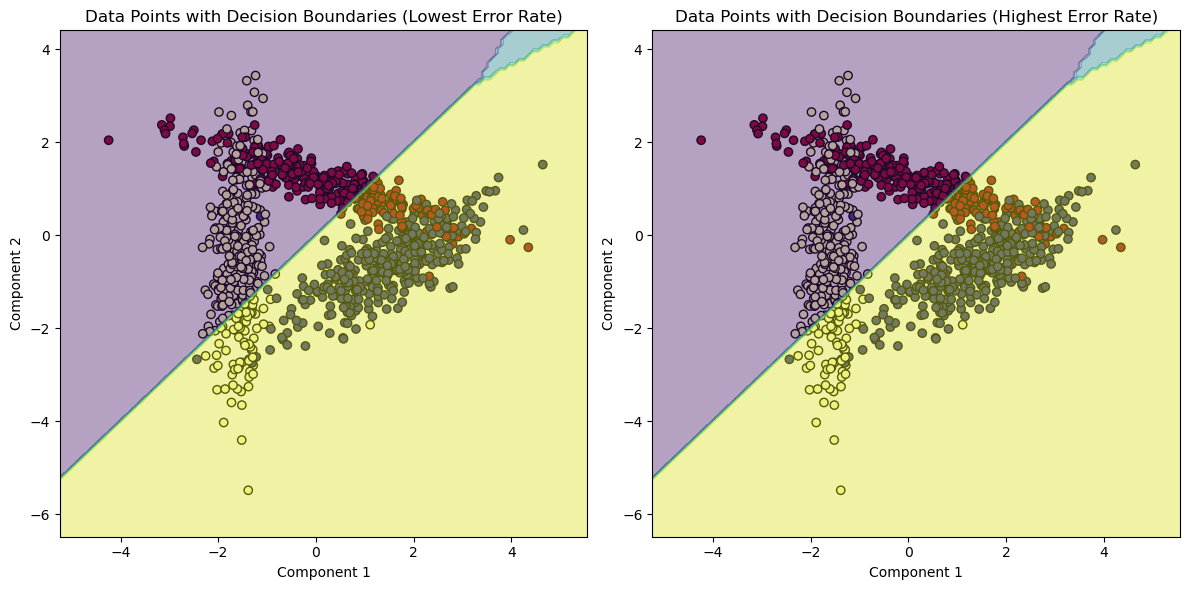

In [21]:
# 2d(ii) - x1,x6 space 

# Instantiate LDA with 2 components
lda = LinearDiscriminantAnalysis(n_components=2)

# Fit LDA to the standardized dataset
X_lda = lda.fit_transform(X_std, y)

# Define the number of runs and folds
num_runs = 5
num_folds = 20

# Initialize lists to store results
mean_error_rates = []
stored_weights = []

# Perform 5 runs
for run in range(num_runs):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=run)
    error_rates = []

    for train_index, _ in kf.split(X_std):
        X_train, y_train = X_std[train_index], y[train_index]
        clf = Perceptron()  # Instantiate perceptron classifier
        clf.fit(X_train[:, [0, 5]], y_train)  # Using only features x1 and x6
        
        # Store weights from the first fold
        if len(error_rates) == 0:
            stored_weights.append(clf.coef_[0])
        
        error_rate = 1 - np.mean(cross_val_score(clf, X_train[:, [0, 5]], y_train, cv=num_folds))
        error_rates.append(error_rate)
    
    mean_error_rate = np.mean(error_rates)
    mean_error_rates.append(mean_error_rate)

# Report mean classification error rate from each run
for i, error_rate in enumerate(mean_error_rates):
    print(f"Run {i+1}: Mean Classification Error Rate = {error_rate:.4f}")

# Report average and standard deviation of the mean classification error over the 5 runs
avg_error_rate = np.mean(mean_error_rates)
std_error_rate = np.std(mean_error_rates)
print(f"\nAverage Mean Classification Error Rate: {avg_error_rate:.4f}")
print(f"Standard Deviation of Mean Classification Error Rate: {std_error_rate:.4f}")

# Find index of run with lowest and highest classification error rates
best_run_index = np.argmin(mean_error_rates)
worst_run_index = np.argmax(mean_error_rates)

# Extract weights from the first fold of the best and worst runs
best_weights = stored_weights[best_run_index]
worst_weights = stored_weights[worst_run_index]

# Plot results for runs with lowest and highest classification error rates
plt.figure(figsize=(12, 6))

# Plot for the run with the lowest classification error rate
plt.subplot(1, 2, 1)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title('Data Points with Decision Boundaries (Lowest Error Rate)')
x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

# Plot for the run with the highest classification error rate
plt.subplot(1, 2, 2)
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k')
plt.title('Data Points with Decision Boundaries (Highest Error Rate)')
x_min, x_max = X_lda[:, 0].min() - 1, X_lda[:, 0].max() + 1
y_min, y_max = X_lda[:, 1].min() - 1, X_lda[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.4)
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.tight_layout()
plt.show()


In [ ]:
# How do you expect a linear classifier to do on this data compared with (b) and (a) above?
# How does it compare with the baselines in (a)(ii) and PCA in (b)(ii)?

# Comparing the performance of Multiple Discriminant Analysis (MDA),
# using Linear Discriminant Analysis (LDA) as an approximation to MDA, 
# on standardized data versus unnormalized data reveals notable differences. 
# In the x1,x6 feature space, MDA on standardized data yields an average mean
# classification error rate of approximately 0.6660, with a standard deviation 
# of 0.0015. This is significantly higher than the average mean classification
# error rate of about 0.3023 observed with PCA on both standardized and 
# unnormalized data in the same feature space. 

# Similarly, in the x1,x2 feature space, MDA on standardized data results
# in an average mean classification error rate of approximately 0.6669, 
# with a standard deviation of 0.0024. Again, this is considerably higher
# than the average mean classification error rate of around 0.5152 observed
# with PCA on standardized data and approximately 0.4584 observed with PCA 
# on unnormalized data in the same feature space.


# These results suggest that MDA, particularly when approximated using LDA,
# may not be as effective as PCA for dimensionality reduction and classification 
# tasks in these specific feature spaces. Standardization appears to have a limited 
# impact on the classification performance of MDA, with the method still exhibiting 
# relatively high error rates compared to PCA. Therefore, for these datasets and
# feature spaces, PCA may be a more suitable choice for dimensionality reduction and classification.


Best gamma: 10
Cross-validation average RMSE: 1.655867935816779e-05
Degrees of freedom (dof): 801.0
Number of centers (noc): 800.0
Best gamma: 10
Best number of centers (K): 100
Cross-validation average RMSE: 0.044153440169986555


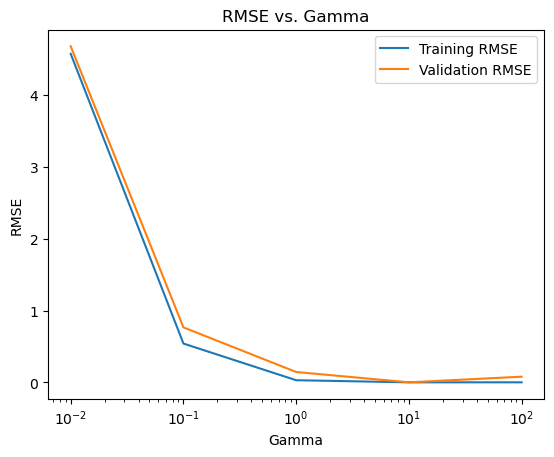

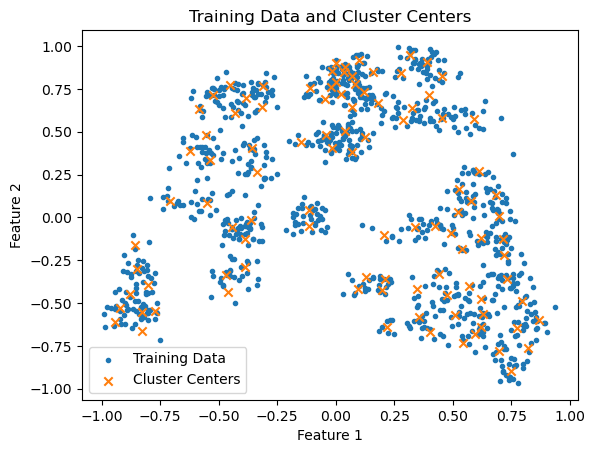

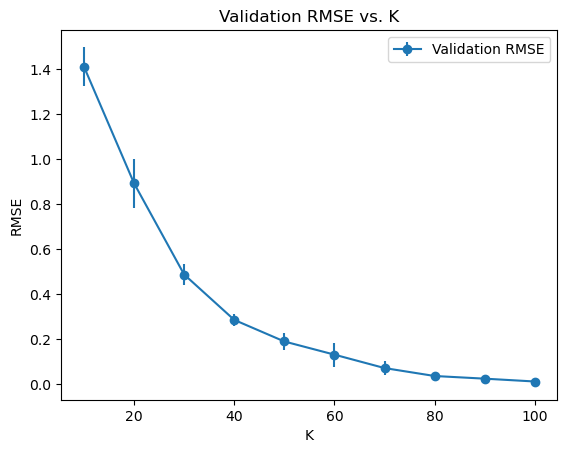

In [36]:
#Problem 3: 

# 1: Load the data
train_data_df = pd.read_csv('HW7_Pr3_S24_training_data.csv')
test_data_df = pd.read_csv('HW7_Pr3_S24_test_data.csv')

X_train_data = train_data_df.iloc[:, :-1].values
y_train_data = train_data_df.iloc[:, -1].values

X_test_data = test_data_df.iloc[:, :-1].values
y_test_data = test_data_df.iloc[:, -1].values

# 2: Define functions
def rbf_kernel(X, centers, gamma):
    return np.exp(-gamma * np.linalg.norm(X[:, np.newaxis] - centers, axis=2) ** 2)

def train_second_layer(X_rbf, y):
    model = LinearRegression()
    model.fit(X_rbf, y)
    return model

def model_selection_rbf(X_train, y_train, gammas):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    best_gamma = None
    best_avg_rmse = float('inf')
    best_dof = None
    best_noc = None

    for gamma in gammas:
        rmse_scores = []
        dof_scores = []
        noc_scores = []

        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            centers = X_train_fold
            X_rbf_train = rbf_kernel(X_train_fold, centers, gamma)
            X_rbf_val = rbf_kernel(X_val_fold, centers, gamma)

            model = train_second_layer(X_rbf_train, y_train_fold)
            dof = (len(model.coef_) + 1)
            noc = len(X_rbf_train)

            y_pred = model.predict(X_rbf_val)

            rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
            rmse_scores.append(rmse)
            dof_scores.append(dof)
            noc_scores.append(noc)

        avg_rmse = np.mean(rmse_scores)
        avg_dof = np.mean(dof_scores)
        avg_noc = np.mean(noc_scores)

        if avg_rmse < best_avg_rmse:
            best_avg_rmse = avg_rmse
            best_gamma = gamma
            best_dof = avg_dof
            best_noc = avg_noc

    return best_gamma, best_avg_rmse, best_dof, best_noc

def model_selection_rbf_kmeans(X_train, y_train, gammas, K_range):
    best_gamma = None
    best_K = None
    best_avg_rmse = float('inf')
    best_dof = None
    best_noc = None

    for gamma in gammas:
        for K in K_range:
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            avg_rmse_scores = []
            dof_scores = []
            noc_scores = []

            for train_index, val_index in kf.split(X_train):
                X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                kmeans = KMeans(n_clusters=K, init='random', n_init=10, random_state=42)
                kmeans.fit(X_train_fold)
                centers = kmeans.cluster_centers_

                X_rbf_train = rbf_kernel(X_train_fold, centers, gamma)
                X_rbf_val = rbf_kernel(X_val_fold, centers, gamma)

                model = train_second_layer(X_rbf_train, y_train_fold)
                dof = (len(model.coef_) + 1)
                noc = len(X_rbf_train)

                y_pred = model.predict(X_rbf_val)

                rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
                avg_rmse_scores.append(rmse)
                dof_scores.append(dof)
                noc_scores.append(noc)

            avg_rmse = np.mean(avg_rmse_scores)
            avg_dof = np.mean(dof_scores)
            avg_noc = np.mean(noc_scores)

            if avg_rmse < best_avg_rmse:
                best_avg_rmse = avg_rmse
                best_gamma = gamma
                best_K = K
                best_dof = avg_dof
                best_noc = avg_noc

    return best_gamma, best_K, best_avg_rmse, best_dof, best_noc

def plot_rmse_vs_gamma(gammas, avg_train_rmse, avg_val_rmse):
    plt.plot(gammas, avg_train_rmse, label='Training RMSE')
    plt.plot(gammas, avg_val_rmse, label='Validation RMSE')
    plt.xlabel('Gamma')
    plt.ylabel('RMSE')
    plt.title('RMSE vs. Gamma')
    plt.xscale('log')
    plt.legend()
    plt.show()

def plot_data_and_centers(X_train, centers):
    plt.scatter(X_train[:, 0], X_train[:, 1], label='Training Data', marker='.')
    plt.scatter(centers[:, 0], centers[:, 1], label='Cluster Centers', marker='x')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Training Data and Cluster Centers')
    plt.legend()
    plt.show()

def plot_rmse_vs_K(K_range, avg_val_rmse_list, std_val_rmse_list):
    plt.errorbar(K_range, avg_val_rmse_list, yerr=std_val_rmse_list, fmt='o-', label='Validation RMSE')
    plt.xlabel('K')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE vs. K')
    plt.legend()
    plt.show()

# 3: Perform Model Selection
gammas_data = [0.01, 0.1, 1, 10, 100]
best_gamma_data, best_avg_rmse_data, best_dof_data, best_noc_data = model_selection_rbf(X_train_data, y_train_data, gammas_data)
print("Best gamma:", best_gamma_data)
print("Cross-validation average RMSE:", best_avg_rmse_data)
print("Degrees of freedom (dof):", best_dof_data)
print("Number of centers (noc):", best_noc_data)

K_range_data = range(10, 101, 10)
best_gamma_data, best_K_data, best_avg_rmse_data, best_dof_data, best_noc_data = model_selection_rbf_kmeans(X_train_data, y_train_data, gammas_data, K_range_data)

print("Best gamma:", best_gamma_data)
print("Best number of centers (K):", best_K_data)
print("Cross-validation average RMSE:", best_avg_rmse_data)

# 4: Plot Results
# Plot RMSE vs. Gamma
avg_train_rmse_list_data = []
avg_val_rmse_list_data = []
for gamma_data in gammas_data:
    rmse_train_list_data = []
    rmse_val_list_data = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index_data, val_index_data in kf.split(X_train_data):
        X_train_fold_data, X_val_fold_data = X_train_data[train_index_data], X_train_data[val_index_data]
        y_train_fold_data, y_val_fold_data = y_train_data[train_index_data], y_train_data[val_index_data]

        centers_data = X_train_fold_data
        X_rbf_train_data = rbf_kernel(X_train_fold_data, centers_data, gamma_data)
        X_rbf_val_data = rbf_kernel(X_val_fold_data, centers_data, gamma_data)

        model_data = train_second_layer(X_rbf_train_data, y_train_fold_data)

        y_pred_train_data = model_data.predict(X_rbf_train_data)
        y_pred_val_data = model_data.predict(X_rbf_val_data)

        rmse_train_data = np.sqrt(mean_squared_error(y_train_fold_data, y_pred_train_data))
        rmse_val_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_val_data))
        rmse_train_list_data.append(rmse_train_data)
        rmse_val_list_data.append(rmse_val_data)

    avg_train_rmse_list_data.append(np.mean(rmse_train_list_data))
    avg_val_rmse_list_data.append(np.mean(rmse_val_list_data))

plot_rmse_vs_gamma(gammas_data, avg_train_rmse_list_data, avg_val_rmse_list_data)

# Plot data and centers
kmeans_data = KMeans(n_clusters=best_K_data, init='random', n_init=10, random_state=42)
kmeans_data.fit(X_train_data)
best_centers_data = kmeans_data.cluster_centers_
plot_data_and_centers(X_train_data, best_centers_data)

# Plot RMSE vs. K
avg_val_rmse_list_data = []
std_val_rmse_list_data = []
for K_data in K_range_data:
    rmse_val_list_data = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index_data, val_index_data in kf.split(X_train_data):
        X_train_fold_data, X_val_fold_data = X_train_data[train_index_data], X_train_data[val_index_data]
        y_train_fold_data, y_val_fold_data = y_train_data[train_index_data], y_train_data[val_index_data]

        kmeans_data = KMeans(n_clusters=K_data, init='random', n_init=10, random_state=42)
        kmeans_data.fit(X_train_fold_data)
        centers_data = kmeans_data.cluster_centers_

        X_rbf_val_data = rbf_kernel(X_val_fold_data, centers_data, best_gamma_data)

        model_data = train_second_layer(X_rbf_val_data, y_val_fold_data)
        y_pred_val_data = model_data.predict(X_rbf_val_data)

        rmse_val_data = np.sqrt(mean_squared_error(y_val_fold_data, y_pred_val_data))
        rmse_val_list_data.append(rmse_val_data)

    avg_val_rmse_list_data.append(np.mean(rmse_val_list_data))
    std_val_rmse_list_data.append(np.std(rmse_val_list_data))

plot_rmse_vs_K(K_range_data, avg_val_rmse_list_data, std_val_rmse_list_data)


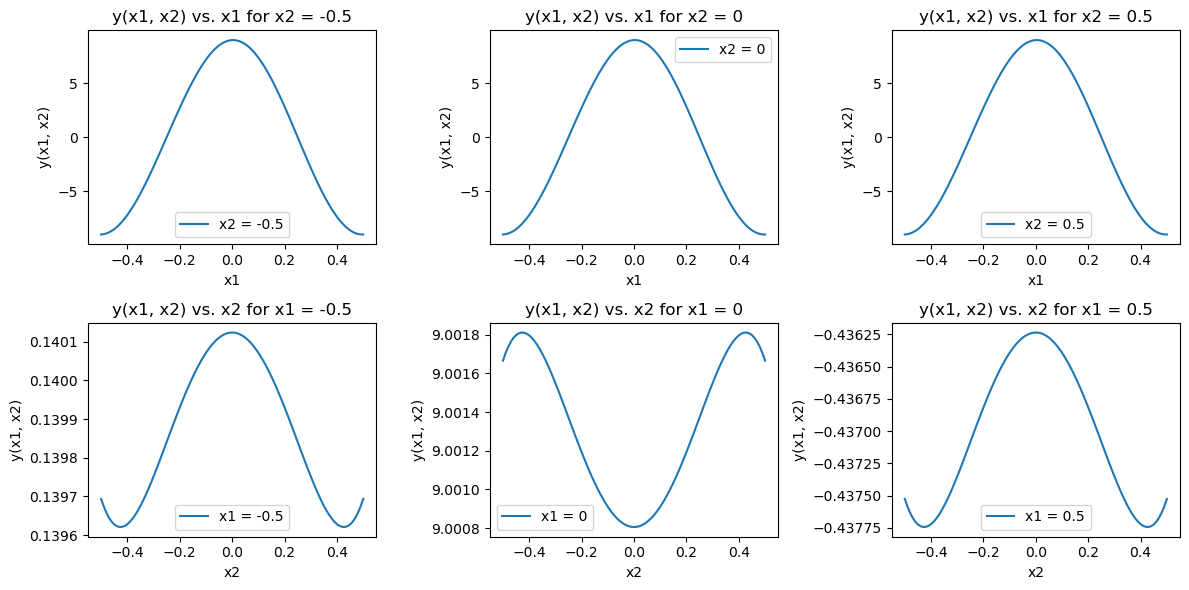

In [39]:
# (h) Visualize the target function
# Part (i) will be integrated into the plotting of the final models in (f)

# Define the target function
def target_function(x1, x2):
    return 9 * np.cos(2 * np.pi * x1) + 0.1 * np.sin(4 * np.pi * x1) * np.sin(np.pi * x2 ** 2 + 1)

# Generate data for visualization
x1_vals = np.linspace(-0.5, 0.5, 100)
x2_vals = np.linspace(-0.5, 0.5, 100)

x1_grid, x2_grid = np.meshgrid(x1_vals, x2_vals)
y_values = target_function(x1_grid, x2_grid)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.plot(x1_vals, y_values[25, :], label='x2 = -0.5')
plt.xlabel('x1')
plt.ylabel('y(x1, x2)')
plt.title('y(x1, x2) vs. x1 for x2 = -0.5')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(x1_vals, y_values[50, :], label='x2 = 0')
plt.xlabel('x1')
plt.ylabel('y(x1, x2)')
plt.title('y(x1, x2) vs. x1 for x2 = 0')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(x1_vals, y_values[75, :], label='x2 = 0.5')
plt.xlabel('x1')
plt.ylabel('y(x1, x2)')
plt.title('y(x1, x2) vs. x1 for x2 = 0.5')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(x2_vals, y_values[:, 25], label='x1 = -0.5')
plt.xlabel('x2')
plt.ylabel('y(x1, x2)')
plt.title('y(x1, x2) vs. x2 for x1 = -0.5')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(x2_vals, y_values[:, 50], label='x1 = 0')
plt.xlabel('x2')
plt.ylabel('y(x1, x2)')
plt.title('y(x1, x2) vs. x2 for x1 = 0')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(x2_vals, y_values[:, 75], label='x1 = 0.5')
plt.xlabel('x2')
plt.ylabel('y(x1, x2)')
plt.title('y(x1, x2) vs. x2 for x1 = 0.5')
plt.legend()

plt.tight_layout()
plt.show()
